# DDPM Coursework Part 2 - Ben Hallett


## Problem 1 - Exploratory Data analysis

## 1.1

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from typing import Tuple, List, Callable
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import BatchNorm1d
from torch.nn.init import xavier_normal_, kaiming_normal_

In [56]:
# global experiment parameters
SAMPLE_RATE = 100 # Hz

In [57]:
# loading data
data_dict = dict(np.load(r'data\\coursework-2024+25-part2.npz'))
data_all = [it[1] for it in data_dict.items()]


In [58]:
print(data_dict.keys())
print(data_dict['x'].shape)
print(data_dict['u'].shape)


dict_keys(['x', 'u'])
(108, 2000)
(108, 2000)


Plotting timeseries data 

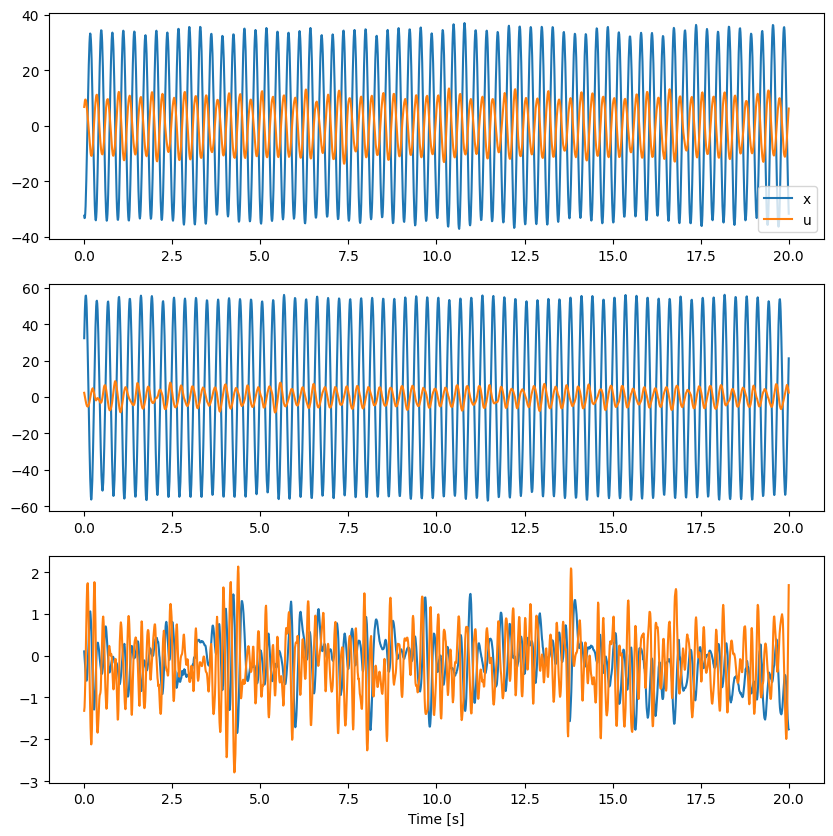

In [59]:
inds = np.random.choice(data_dict['x'].shape[0], 3, replace=False)

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
t = np.linspace(0, data_dict['x'].shape[1] / SAMPLE_RATE, data_dict['x'].shape[1])
for i, ind in enumerate(inds):
    axs[i].plot(t, data_dict['x'][ind], label='x')
    axs[i].plot(t, data_dict['u'][ind], label='u')
    
axs[0].legend()
axs[2].set_xlabel('Time [s]')
plt.show()
    


We can see that each timeseries is 20 seconds long and that the forcing seems to either be in phase with the displacement or 180 degrees out of phase, at least for the series visualised here. Additionally we can see there is variation in the amplitufe of displacement and forcing and that the amplitude remains roughly constant for each timeseries.

## 1.2
calculating standard deviation of each timeseries and plotting std(x) against std(u)

Text(0, 0.5, 'std(u)')

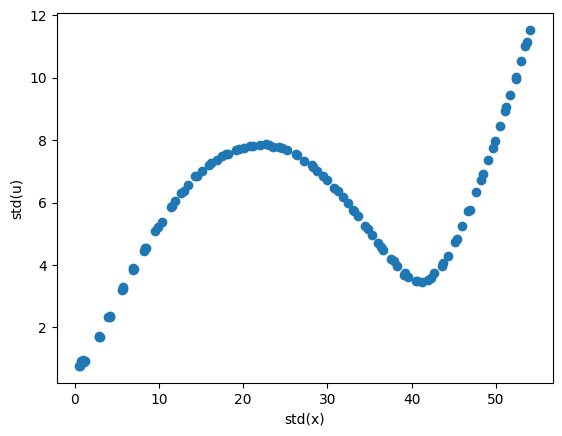

In [60]:
X = data_dict['x']
U = data_dict['u']

X_std = np.std(X, axis=1)
U_std = np.std(U, axis=1)

plt.plot(X_std, U_std, 'o')
plt.xlabel('std(x)')
plt.ylabel('std(u)')

We see that there appears to be a cubic function mapping std(x) to std(u) but there is no function mapping std(u) to std(x). So the force amplitude can be determined from the displacement amplitude, but not vice versa. Additionally we see that, perhaps somewhat unexpectedly the force amplitude actually decreases past a certain displacement amplitude, before increasing again. All of this implies that we cannot learn a function that takes input u and predicts the state x.

## 1.3
Truncating each time series to the first 200 measurements

In [61]:
X = X[:, :200]
U = U[:, :200]

print(X.shape, U.shape)

(108, 200) (108, 200)


## 1.4
To normalise so that each timeseries has a maximum amplitude of one we can do the following 

In [62]:
X_max = np.max(X.flatten())
U_max = np.max(U.flatten())

X = X / X_max
U = U / U_max

assert np.max(X.flatten()) == 1
assert np.max(U.flatten()) == 1

print(X.shape, U.shape)
print(np.max(X, axis=1))
print(np.mean(np.max(X, axis=1)))


(108, 200) (108, 200)
[0.01997505 0.03384327 0.06508288 0.09332182 0.11134887 0.13883644
 0.16588659 0.19949803 0.22109718 0.25413721 0.28849332 0.32210667
 0.32874263 0.37374038 0.39131566 0.42708836 0.45184899 0.49831311
 0.53927933 0.56399594 0.59510538 0.61800435 0.64988621 0.66697621
 0.69865707 0.71524839 0.7531364  0.78991124 0.80620106 0.82342889
 0.87181401 0.89930733 0.92390237 0.93810463 0.98142258 0.98479847
 0.01330847 0.03696455 0.05861634 0.08609051 0.11125124 0.13823056
 0.16752619 0.17859569 0.22282963 0.23322816 0.27428818 0.29057321
 0.32753948 0.36346054 0.39307969 0.41433714 0.43054752 0.47675894
 0.51850429 0.53223084 0.57621593 0.60591166 0.63703833 0.6626269
 0.67888896 0.71121207 0.73383825 0.76293001 0.79042811 0.81844211
 0.85991658 0.88796313 0.90119866 0.93267278 0.9591965  1.
 0.01474612 0.02350887 0.08179863 0.09169083 0.12451932 0.14314555
 0.15605182 0.17096429 0.22248697 0.25047035 0.28045322 0.30334453
 0.33832279 0.35552764 0.37998582 0.41152885 0.46

## Problem 2 - Echo State Networks

## 2.1

In [63]:
def train_test_split(train_ratio, size, val_ratio=0):
    """
    splits the full dataset into training and test sets

    args:
    ------
    train_ratio : float
        The ratio of the dataset to use for training
    size : int
        The size of the dataset
    val_ratio : float, optional (default is 0)
        The ratio of the dataset to use for validation

    returns:
    --------
    train_inds : ndarray
        The indices of the training set
    test_inds : ndarray
        The indices of the test set
    val_inds : ndarray
        The indices of the validation set (if val_ratio > 0)
    """
    # again let's do a 60-40 split, this time splitting by trial
    split_pos = round(train_ratio*size)
    random_inds = np.random.permutation(size)
    train_inds = random_inds[:split_pos]
    test_inds = random_inds[split_pos:]

    if val_ratio > 0:
        val_pos = round(val_ratio*size)
        val_inds = test_inds[:val_pos]
        test_inds = test_inds[val_pos:]

        return train_inds, test_inds, val_inds
    
    return train_inds, test_inds

sampling the timeseries which have a displacement standard deviation greater than 42 and splitting the data into training and testing sets. Note I have lagged the inputs (force) and outputs (displacement) prior to flattening the data, so that predictions are always occuring on within the same time series during training.

In [64]:
sample_inds = []
for i in range(X.shape[0]):
    sample_std = np.std(X[i, :]*X_max)
    if sample_std >= 42:
        print(f'Found sample with std >= 42: {i}')
        sample_inds.append(i)

X_samples = X[sample_inds, :]
U_samples = U[sample_inds, :]

# taking a 60-40 train-test split
train_inds, test_inds = train_test_split(0.6, len(sample_inds))

# lagging the inputs by one time step for prediction
X_train = X_samples[train_inds, 1:]
U_train = U_samples[train_inds, :-1]
X_test = X_samples[test_inds, 1:]
U_test = U_samples[test_inds, :-1]

print("train and test data shapes pre flattening:")
print(X_train.shape, U_train.shape, X_test.shape, U_test.shape)

# flattening, to remove batch dimension
X_train = X_train.flatten()[:, np.newaxis]
U_train = U_train.flatten()[:, np.newaxis]
X_test = X_test.flatten()[:, np.newaxis]
U_test = U_test.flatten()[:, np.newaxis]

print("train and test data shapes:")
print(X_train.shape, U_train.shape, X_test.shape, U_test.shape)

Found sample with std >= 42: 27
Found sample with std >= 42: 28
Found sample with std >= 42: 29
Found sample with std >= 42: 30
Found sample with std >= 42: 31
Found sample with std >= 42: 32
Found sample with std >= 42: 33
Found sample with std >= 42: 34
Found sample with std >= 42: 35
Found sample with std >= 42: 64
Found sample with std >= 42: 65
Found sample with std >= 42: 66
Found sample with std >= 42: 67
Found sample with std >= 42: 68
Found sample with std >= 42: 69
Found sample with std >= 42: 70
Found sample with std >= 42: 71
Found sample with std >= 42: 99
Found sample with std >= 42: 100
Found sample with std >= 42: 101
Found sample with std >= 42: 102
Found sample with std >= 42: 103
Found sample with std >= 42: 104
Found sample with std >= 42: 105
Found sample with std >= 42: 106
Found sample with std >= 42: 107
train and test data shapes pre flattening:
(16, 199) (16, 199) (10, 199) (10, 199)
train and test data shapes:
(3184, 1) (3184, 1) (1990, 1) (1990, 1)


## 2.2

ESN Code from workshop

In [65]:
def create_reservoir(size, in_size=1, spectral_radius=0.9):
    """
    Create a reservoir with the given size and spectral radius.

    Parameters
    ----------
    size : int
        The number of neurons in the reservoir.
    in_size : int, optional (default is 1)
        The number of input neurons.
    spectral_radius : float, optional (default is 0.9)
        The desired spectral radius of the reservoir weight matrix.

    Returns
    -------
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    """
    # Create a random reservoir matrix with elements in [-0.5, 0.5]
    W = np.random.rand(size, size) - 0.5
    # Set diagonal elements to zero (no self feedback)
    np.fill_diagonal(W, 0)
    # Scale the matrix to have spectral radius = spectral_radius
    max_eig = np.max(np.abs(np.linalg.eigvals(W)))
    W *= spectral_radius / max_eig
    # Create a random input matrix with elements in [-0.5, 0.5]
    Win = np.random.rand(size, in_size) - 0.5
    return W, Win

def run_reservoir(W, Win, u, x = None):
    """
    Run the reservoir with the given input.

    Parameters
    ----------
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    u : ndarray
        The input signal matrix. shape = (n_samples, n_inputs)
    x : ndarray, optional
        The initial state vector of the reservoir. If not provided, it is set to zero.

    Returns
    -------
    all_x : ndarray
        The state vectors of the reservoir at each time step.
    """
    # Initialize the state vector if needed
    if x is None:
        x = np.zeros(W.shape[0])
    # Run the reservoir and store the state vectors
    all_x = np.zeros((u.shape[0], W.shape[0]))
    for i in range(u.shape[0]):
        # Evaluate the reservoir (hidden layer) at the current time step
        x = np.tanh(np.dot(W, x) + np.dot(Win, u[i, :]))
        all_x[i, :] = x
    return all_x

def train_reservoir(all_x, y):
    """
    Train the output weights of the reservoir.

    Parameters
    ----------
    all_x : ndarray
        The state vectors of the reservoir at each time step.
    y : ndarray
        The target output signal matrix. shape = (n_samples, n_outputs)

    Returns
    -------
    Wout : ndarray
        The output weight matrix.
    """
    # Solve for the output weights using least squares
    return np.linalg.lstsq(all_x, y, rcond=None)[0]

def predict_reservoir(Wout, W, Win, u):
    """
    Predict the output signal of the reservoir.

    Parameters
    ----------
    Wout : ndarray 
        The output weight matrix.
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    u : ndarray
        The input signal matrix.

    Returns
    -------
    y : ndarray
        The predicted output signal matrix.
    """
    # Initialize the state vector
    x = np.zeros(W.shape[0])
    # Run the reservoir and predict the output
    y = np.zeros((u.shape[0], Wout.shape[1]))
    for i in range(u.shape[0]):
        # Evaluate the reservoir (hidden layer) at the current time step
        x = np.tanh(np.dot(W, x) + np.dot(Win, u[i, :]))
        y[i, :] = np.dot(Wout.T, x)
    return y

creating and training an initial ESN on the training data for std(x) >= 42. Since the input is external, we cannot predict it so it should form the input to the ESN. The output of the ESN is the estimate of the displacement of the system at each timestep, based on the current force input and previous force inputs, which are reccurently embedded in the hidden layer.

In [66]:
def train_esn(size, spectral_radius, train_in, train_out):
    """
    Train and predict using an Echo State Network (ESN) with the given parameters.

    args:
    ------
    size : int
        The number of neurons in the reservoir.
    spectral_radius : float
        The desired spectral radius of the reservoir weight matrix
    train_in : ndarray
        The training data to use for training the ESN, with shape (n_samples, n_features)
    train_out : ndarray
        The target data to use for training the ESN, with shape (n_samples, n_features)
    
    
    returns:
    --------
    W_in : ndarray
        The input weight matrix
    W : ndarray
        The reservoir weight matrix
    W_out : ndarray
        The output weight matrix
    """
    # creating the reservoir with input size 2, corresponding to x 
    W, W_in = create_reservoir(size=size, in_size=train_in.shape[1], spectral_radius=spectral_radius)
    # running the reservoir with the training data to generate hidden layer states
    hidden = run_reservoir(W, W_in, train_in)
    # time shifted by 1 so that the network learns to predict the next state
    W_out = train_reservoir(hidden, train_out) 

    return W_in, W, W_out

In [67]:
# training the ESN with a reservoir size of 100 and spectral radius of 0.9
W_in, W, W_out = train_esn(50, 0.9, train_in=U_train, train_out=X_train)

now let's visualise the predicted displacement trajectories against the actual trajectories for a single timeseries.

In [68]:
train_preds = predict_reservoir(W_out, W, W_in, U_train)
print("train preds shape:")
print(train_preds.shape)

train preds shape:
(3184, 1)


train/test predictions shape:
(199, 1) (199, 1)


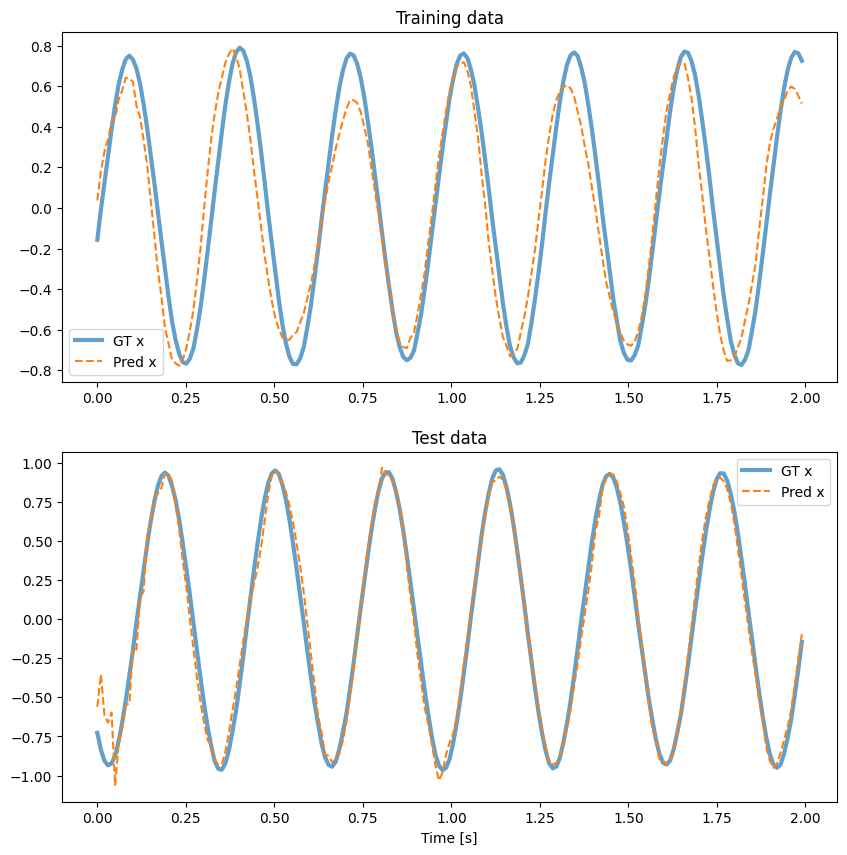

In [69]:
# making training and test predictions
train_preds = predict_reservoir(W_out, W, W_in, U_train[:199])
test_preds = predict_reservoir(W_out, W, W_in, U_test[:199])

print("train/test predictions shape:")
print(train_preds.shape, test_preds.shape)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, (data, preds) in enumerate(zip([X_train[:199], X_test[:199]], [train_preds, test_preds])): # removing the initial condition from preds, so that the shapes match
    t = np.linspace(0, data.shape[0]/SAMPLE_RATE, data.shape[0])
    axs[i].plot(t, data, label='GT x', linewidth=3, alpha=0.7)
    axs[i].plot(t, preds, label='Pred x', linestyle='--')
    axs[i].legend()

axs[1].set_xlabel('Time [s]')
axs[0].set_title('Training data')
axs[1].set_title('Test data')
plt.show()


We see pretty good agreement between the training and testing data predictions and their respective ground truths. Although we can see that the network takes some time to converge to stable predictions during its warmup period for both training and testing data. Let's calculate the MSE accross the training and testing sets to verify this pattern holds. To visualise the uncertainty in the MSE we can also plot a histogram of the MSE accross each timeseries individually.

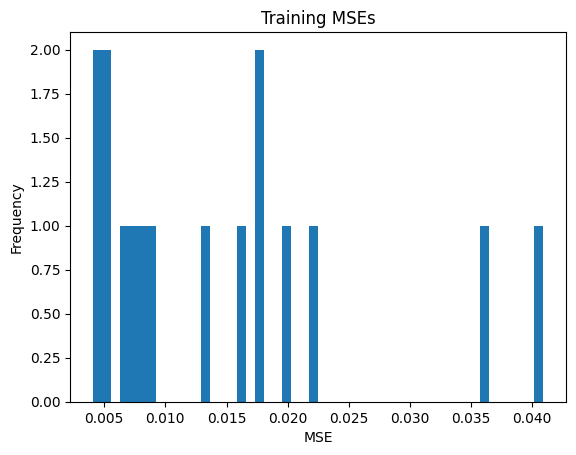

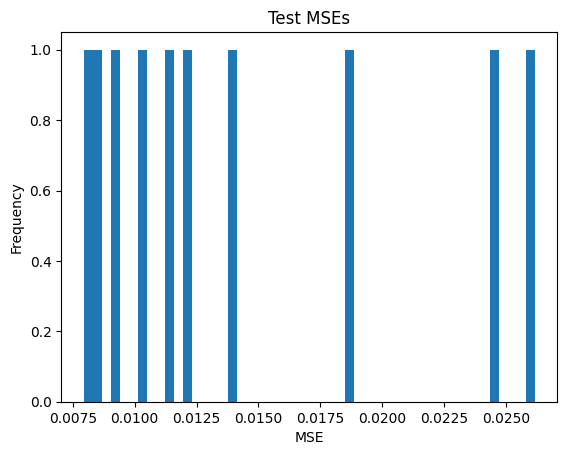

Training MSE: 0.014625516601435124
Test MSE: 0.014276982165733504


In [70]:
def calc_mse(gt, pred):
    return np.mean((gt - pred)**2)

def get_num_series(U, series_len=199):
    # figuring out how many time series we have from the series_length
    assert U.shape[0] % series_len == 0
    no_series = int(U.shape[0] / series_len)
    return no_series
   
def calc_pred_mse(W_out, W, W_in, U, X, series_len=199):
    no_series = get_num_series(U, series_len)

    mses = []
    for i in range(no_series):
        series_inds = range(i*series_len,(i+1)*series_len)
        pred = predict_reservoir(W_out, W, W_in, U[series_inds])
        mses.append(calc_mse(X[series_inds], pred))

    mean_error = np.mean(mses) # this is ok since all series are the same length

    return mses, mean_error

def visualise_mse_hist(mses, title):
    plt.hist(mses, bins=50)
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

train_mses, train_error = calc_pred_mse(W_out, W, W_in, U_train, X_train)
test_mses, test_error = calc_pred_mse(W_out, W, W_in, U_test, X_test)

visualise_mse_hist(train_mses, 'Training MSEs')
visualise_mse_hist(test_mses, 'Test MSEs')

print(f'Training MSE: {train_error}')
print(f'Test MSE: {test_error}')

We see that the total MSE is similar for both the training and testing data and looking at the histograms we see that the uncertainty in the MSE seems to be a little bit higher for the testing data.

## 2.3
Let's perform a grid search over the hyperparameters and select those which minimize the training loss. There are two hyperparameters, hidden_size and spectral radius.


In [71]:
def esn_gridsearch(hidden_sizes:List, spectral_radius:List, train_in, train_out, test_in, test_out):
    # mse matrix to store the mse values for each combination of hidden size and spectral radius
    train_mse_mat = np.ones((len(hidden_sizes), len(spectral_radius)))*np.inf
    test_mse_mat = np.copy(train_mse_mat)

    for i, hs in tqdm(enumerate(hidden_sizes), desc="grid search progress", total=len(hidden_sizes)):
        for j, sr in enumerate(spectral_radius):
            W_in, W, W_out = train_esn(hs, sr, train_in, train_out)
            
            # calculating the mse for the training and test sets over all time series
            # its ok to take the mean of a set of means here, because the time series are all the same length
            _, train_mse = calc_pred_mse(W_out, W, W_in, train_in, train_out)
            _, test_mse = calc_pred_mse(W_out, W, W_in, test_in, test_out)

            train_mse_mat[i, j] = train_mse
            test_mse_mat[i, j] = test_mse

    # opt_hs, opt_sr = np.unravel_index(np.argmin(train_mse_mat), train_mse_mat.shape)

    return train_mse_mat, test_mse_mat

we can visualise the MSE matrix from the gridsearch to get a sense for the effect of the different hyperparameters.

In [72]:
def plot_mse_mat(ax, mse_mat, hs_list, sr_list, norm=LogNorm()):
    cax = ax.matshow(mse_mat, cmap='jet', norm=norm)
    # formatting 
    ax.set_xticks(np.arange(0, len(sr_list), 2))
    ax.set_xticklabels([f'{sr_list[k]:.2f}' for k in range(0, len(sr_list), 2)])
    ax.set_yticks(np.arange(len(hs_list)))
    ax.set_yticklabels([f'{hs}' for hs in hs_list])
    ax.set_xlabel('Spectral radius')
    ax.set_ylabel('Hidden size')

    return cax

def plot_mse_mats(train_mat, test_mat, hs_list, sr_list):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # combined norm so that a single colorbar can be used
    combined = np.vstack([train_mat, test_mat]).flatten()
    norm = LogNorm(vmin=np.min(combined), vmax=np.max(combined))

    for i, mat in enumerate([train_mat, test_mat]):
        cax = plot_mse_mat(axs[i], mat, hs_list, sr_list, norm=norm)

    fig.colorbar(cax, ax=axs, label='MSE')
    axs[0].set_title('Training MSE')
    axs[1].set_title('Test MSE')
    plt.show()

grid search progress: 100%|██████████| 11/11 [01:13<00:00,  6.66s/it]


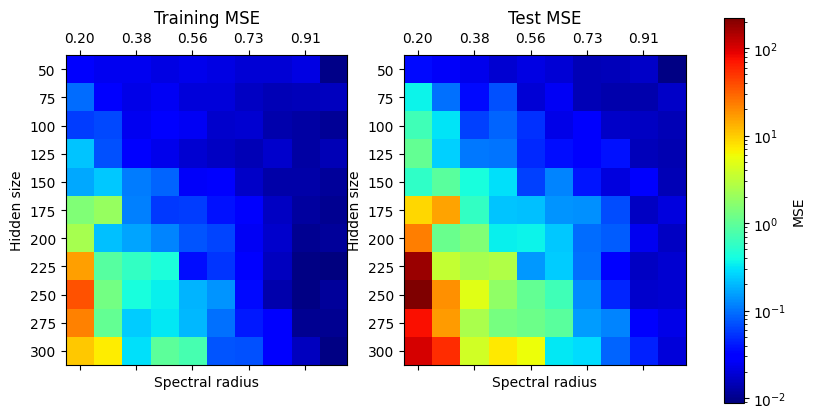

In [73]:
hs_list = np.arange(50, 301, 25)
sr_list = np.linspace(0.2, 1, 10)

train_mse, test_mse = esn_gridsearch(hs_list, sr_list, U_train, X_train, U_test, X_test)
plot_mse_mats(train_mse, test_mse, hs_list, sr_list)


We can see that larger hidden sizes and a spectral radius close to 1 produce the best train MSE, however there appears to be some overfitting associated with larger hidden sizes, as we can see the test MSE is larger for large hidden sizes and especially for small spectral radius. If we were to simply select the hyperparameters corresponding to the best training MSEs, we would likely have an overfit model that performs worse on the test data. So a better approach is to select the hyperparameters based on the test MSEs. This gives us the following hyperparameters, which we will use when training on the whole dataset.

In [74]:
best_hs, best_sr = np.unravel_index(np.argmin(test_mse), test_mse.shape)
best_hs = hs_list[best_hs]
best_sr = sr_list[best_sr]

print(f'Best hidden size: {best_hs}')
print(f'Best spectral radius: {best_sr}')

# test mse with the tuned hyperparameters
W_in, W, W_out = train_esn(best_hs, best_sr, train_in=U_train, train_out=X_train)
_, test_mse = calc_pred_mse(W_out, W, W_in, U_test, X_test)
print(f'Test MSE with tuned hyperparameters: {test_mse}')

Best hidden size: 50
Best spectral radius: 1.0
Test MSE with tuned hyperparameters: 0.016700883539759147


We actually don't see any significant loss reduction. This suggests that we may be reaching the minimum loss of the ESN, or that the main bottleneck is the amount of data. Lets visualise the standard deviation space, from our data visualisation. 

In [75]:

def visualise_amplitude_space(U, X, X_pred, series_len=199):
    no_series = get_num_series(U, series_len)

    U_stds = []
    X_stds = []
    pred_stds = []
    for i in range(no_series):
        # calculating stds for each series
        series_inds = range(i*series_len,(i+1)*series_len)
        std_x = np.std(X[series_inds])
        std_u = np.std(U[series_inds])
        pred_std = np.std(X_pred[series_inds])
        # storing
        U_stds.append(std_u)
        X_stds.append(std_x)
        pred_stds.append(pred_std)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(X_stds, U_stds, 'x', label='GT')
    ax.plot(pred_stds, U_stds, 'o', label='Pred')
    ax.set_xlabel('std(x)')
    ax.set_ylabel('std(u)')
    ax.legend()
    plt.show()

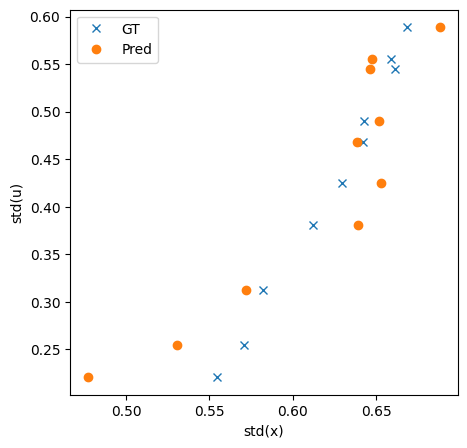

In [76]:
test_preds = predict_reservoir(W_out, W, W_in, U_test)
visualise_amplitude_space(U_test, X_test, test_preds)

We see that the model seems to have learnt an approximately linear fit of the ground truth standard deviation. For this range, we see that this is a good approximation since there is a one to one mapping from displacement std to force std.

## 2.4
Now lets retrain on the entire dataset using the hyperparameters from the grid_search.

In [77]:
train_inds, test_inds = train_test_split(0.6, X.shape[0])

X_train = X[train_inds, 1:]
U_train = U[train_inds, :-1]
X_test = X[test_inds, 1:]
U_test = U[test_inds, :-1]

X_train = X_train.flatten()[:, np.newaxis]
U_train = U_train.flatten()[:, np.newaxis]
X_test = X_test.flatten()[:, np.newaxis]
U_test = U_test.flatten()[:, np.newaxis]

print("train and test data shapes:")
print(X_train.shape, U_train.shape, X_test.shape, U_test.shape)


train and test data shapes:
(12935, 1) (12935, 1) (8557, 1) (8557, 1)


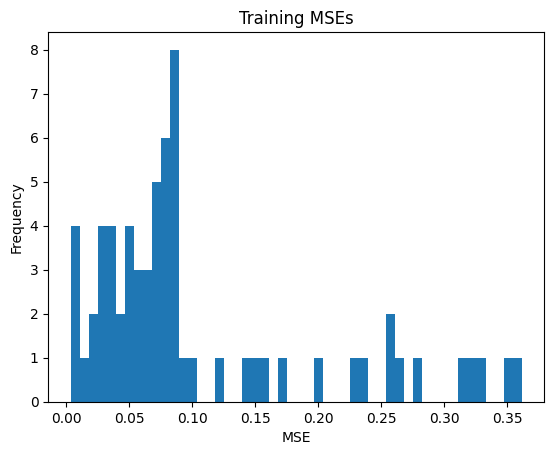

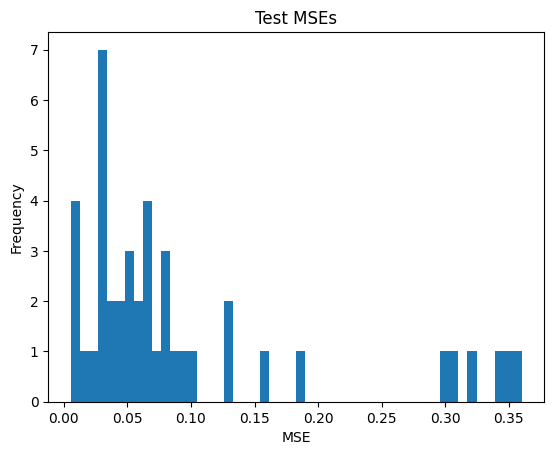

Training MSE: 0.10549047611339957
Test MSE: 0.0968820395796241


In [78]:
W_in, W, W_out = train_esn(best_hs, best_sr, U_train, X_train)

train_mses, train_error = calc_pred_mse(W_out, W, W_in, U_train, X_train)
test_mses, test_error = calc_pred_mse(W_out, W, W_in, U_test, X_test)

visualise_mse_hist(train_mses, 'Training MSEs')
visualise_mse_hist(test_mses, 'Test MSEs')

print(f'Training MSE: {train_error}')
print(f'Test MSE: {test_error}')

we see after training on the whole dataset, that the training and testing MSE are both about an order of magnitude worse. Let's visualise the standard deviation of predictions against force input to see why this might be.

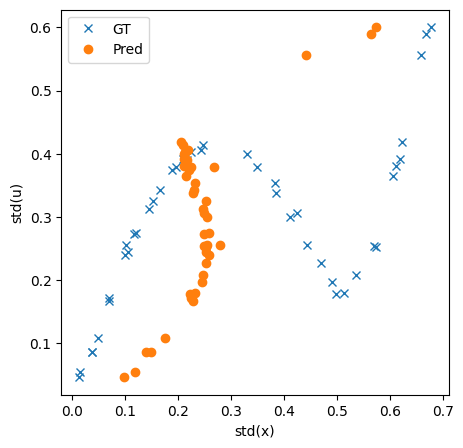

In [80]:
test_preds = predict_reservoir(W_out, W, W_in, U_test)
visualise_amplitude_space(U_test, X_test, test_preds)

We can see that, that the model has learned a one-to-one mapping from std of force to std of displacement, which doesn't represent the data. We can see that most of the predictions lay between std(x) = 0.1 and 0.3, probably because this minimises the loss with the low and high amplitude displacements caused by this force range.

## Problem 3 - RNNs

## 3.1
Since we are now training a deeper network, it makes sense to use a train-test-val split so that we can implement early stopping during training, to avoid overfitting.
We will keep the proportion of training data the same, so that we have a 60-20-20 train-test-val split.

In [99]:
train_inds, test_inds, val_inds = train_test_split(0.59, X.shape[0], val_ratio=0.205) # tweaked a bit so that there are 2^6 samples in the training set

# splitting data into (batch, time, features)
U_train = torch.from_numpy(np.stack([X[train_inds, :-1], U[train_inds, :-1]], axis=-1)) # input force and displacement
X_train = torch.from_numpy(X[train_inds, 1:]) # output states
U_test = torch.from_numpy(np.stack([X[test_inds, :-1], U[test_inds, :-1]], axis=-1))
X_test = torch.from_numpy(X[test_inds, 1:])
U_val = torch.from_numpy(np.stack([X[val_inds, :-1], U[val_inds, :-1]], axis=-1))
X_val = torch.from_numpy(X[val_inds, 1:])

# converting the data to float32 for training
U_train = U_train.float()
X_train = X_train.float().unsqueeze(-1)
U_test = U_test.float()
X_test = X_test.float().unsqueeze(-1)
U_val = U_val.float()
X_val = X_val.float().unsqueeze(-1)

print(U_train.shape, X_train.shape, U_test.shape, X_test.shape, U_val.shape, X_val.shape)

torch.Size([64, 199, 2]) torch.Size([64, 199, 1]) torch.Size([22, 199, 2]) torch.Size([22, 199, 1]) torch.Size([22, 199, 2]) torch.Size([22, 199, 1])


## 3.2 and 3.3

We can use the Pytorch implementation of a vanilla RNN and create a RNN_Net class as a wrapper, which implements a fully connected output layer, to make predictions from the hidden layer activations.

In [100]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class RNN_Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=1, nonlinearity='relu', bias=True, device=DEVICE)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, return_hidden=False, hidden=None):
        if hidden is None:
            out, hidden = self.rnn(x)
        else:
            out, hidden = self.rnn(x, hidden)
        
        out = self.fc(out)
        
        if return_hidden:
            return out, hidden
        return out


Below is a training script which I should be able to use with any reccurent DNN, which implements early stopping based on the validation, as well as gradient clipping and an exponential learning rate scheduler.

In [101]:

def train_rnn(net: nn.Module, train_in, train_out, val_in, val_out, batch_size=32, 
              num_epochs: int = 100, learning_rate: float = 0.01, betas: Tuple = (0.9, 0.999), clip_thresh: float = 1):
    """
    Trains RNN based net model for num_epochs epochs, using BPTT with cross entropy loss and Adam optimizer. 
    The learning rate is decayed exponentially using a scheduler so that the final learning rate is 1% of the
    initial learning rate.

    args:
    -----
    net: nn.Module - RNN network to train
    train_in: torch.Tensor - input training data (batch, time, features)
    train_out: torch.Tensor - output training data (batch, time, features)
    val_in: torch.Tensor - input validation data (batch, time, features)
    val_out: torch.Tensor - output validation data (batch, time, features)

    optional:
    ---------
    batch_size: int - batch size for training. Default is 32
    num_epochs: int - number of epochs to train the model for. Default is 100
    learning_rate: float - learning rate for the Adam optimizer. Default is 0.001
    betas: Tuple - betas for the Adam optimizer. Default is (0.9, 0.999)
    clip_thresh: float - threshold for gradient clipping. Default is 1

    returns:
    --------
    net: nn.Module - best performing model instance
    training_log: dict - dictionary containing training and validation loss, learning rate and epoch number
    """
    
    # loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=betas)
    # using exponential learning rate scheduler for better stability once the loss is small.
    gamma = 0.01**(1/num_epochs) # setting gamma so that the final learning rate is 1% of the initial learning rate
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    # training log
    training_log = {'train_loss': [],  
                    'val_loss': [],
                    'learning_rate': [],
                    'epoch': []}

    # determining the number of batches per epoch
    batches = train_in.shape[0] // batch_size
    if train_in.shape[0] % batch_size > 0:
        batches += 1

    best_model = None
    best_loss = np.inf
    
    # moving everything to the same device
    net = net.to(DEVICE)
    train_in = train_in.to(DEVICE)
    train_out = train_out.to(DEVICE)
    val_in = val_in.to(DEVICE)
    val_out = val_out.to(DEVICE)
    
    # training loop using BPTT
    for epoch in range(num_epochs):
        training_log['epoch'].append(epoch+1)
        # training phase
        net.train()    
        for batch in range(batches):
            optimizer.zero_grad() # zeroing gradients before each forward pass to avoid accumulation
            
            # getting the current batch from the training data
            train_in_batch = train_in[batch*batch_size:(batch+1)*batch_size, :, :]
            train_out_batch = train_out[batch*batch_size:(batch+1)*batch_size, :, :]

            # skipping last sequence element for prediction
            train_pred = net(train_in_batch) # output shape should be (batch_size, seq_len, output_size)
            assert train_pred.shape == train_out_batch.shape, f'Output shape: {train_pred.shape}, target shape: {train_out_batch.shape}'
            
            # calculating loss and backpropagating
            loss = criterion(train_pred, train_out_batch) # skipping first element to get target sequence
        
            loss.backward()
            # implementing gradient clipping before stepping the optimizer
            nn.utils.clip_grad_norm_(net.parameters(), clip_thresh)
            optimizer.step()
        
        # validation phase
        net.eval()
        with torch.no_grad():
            val_pred = net(val_in)
            val_loss = criterion(val_pred, val_out)
            
        # stepping the learning rate scheduler
        training_log['learning_rate'].append(scheduler.get_last_lr()[0])
        scheduler.step() # decaying the learning rate by gamma
        
        # logging training and validation loss at the end of each epoch
        training_log['train_loss'].append(loss.item())
        training_log['val_loss'].append(val_loss.item())
        
        # saving best model
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_model = net.state_dict()

        if (epoch+1) % 10 == 0:
            print('--------------------------------')
            print(f'Epoch {epoch+1}, train Loss: {loss.item()}, val loss: {val_loss.item()}')
            print('--------------------------------\n')

    # once training is complete, we can load the best model, and return the training log
    net.load_state_dict(best_model)
    return net, training_log

For this approach, we are passing in the force and displacement at the current timestep and we want the RNN to predict the next displacement. This approach should get around the limitation witnessed with the ESN, since the network will hopefully be able to determine the amplitude based on the change in displacement in the previous timesteps, combined with the forcing.

In [102]:
vanilla_rnn = RNN_Net(input_size=2, hidden_size=20, output_size=1)
vanilla_rnn, training_log = train_rnn(vanilla_rnn, U_train, X_train, U_val, X_val, num_epochs=500, learning_rate=0.01, batch_size=32)

--------------------------------
Epoch 10, train Loss: 0.02563551627099514, val loss: 0.03198767825961113
--------------------------------

--------------------------------
Epoch 20, train Loss: 0.0025805665645748377, val loss: 0.003501054598018527
--------------------------------

--------------------------------
Epoch 30, train Loss: 0.0008581727161072195, val loss: 0.0011121812276542187
--------------------------------

--------------------------------
Epoch 40, train Loss: 0.0006115016294643283, val loss: 0.0006751589826308191
--------------------------------

--------------------------------
Epoch 50, train Loss: 0.00045662454795092344, val loss: 0.0005085309967398643
--------------------------------

--------------------------------
Epoch 60, train Loss: 0.0003782261337619275, val loss: 0.00042732266592793167
--------------------------------

--------------------------------
Epoch 70, train Loss: 0.00033185386564582586, val loss: 0.00037648031138814986
---------------------------

plotting the results

In [103]:
def visualise_training_log(training_log):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(training_log['epoch'], training_log['train_loss'], label='Training loss')
    ax.plot(training_log['epoch'], training_log['val_loss'], label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title('Training and validation curves')
    plt.show()

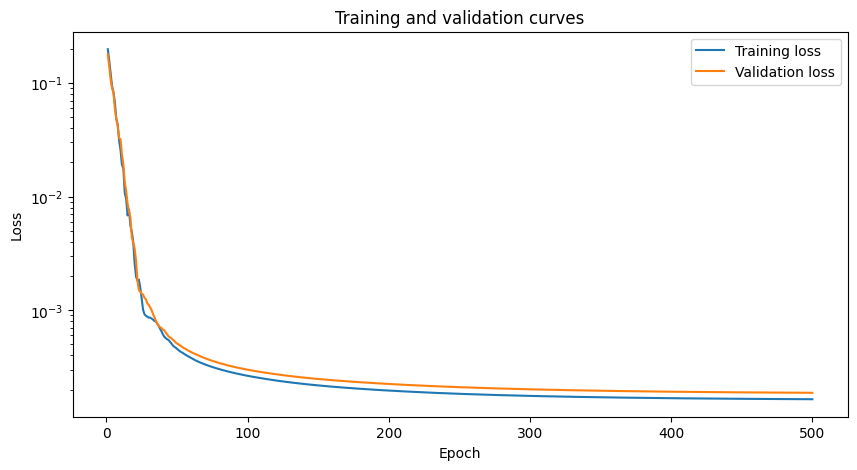

Test loss: 0.00021915430261287838


In [104]:
visualise_training_log(training_log)

# getting the testing loss
vanilla_rnn.eval()
with torch.no_grad():
    test_output = vanilla_rnn(U_test.to(DEVICE))
    test_loss = nn.MSELoss()(test_output, X_test.to(DEVICE))

print(f'Test loss: {test_loss.item()}')

We see good agreement between the training and validation loss throughout training, with some perhaps very slight overfitting as the loss gets very low. Additionally we see that the test loss evaluated on the held out test data is similar to the observed training and validation loss at epoch 200.

let's take a quick look at the standard deviation plot to see what it looks like now

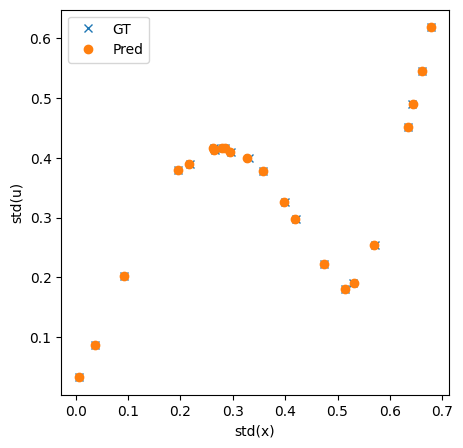

In [105]:
# bit of jiggery pokery here to get everything in the expected format
visualise_amplitude_space(U_test[:,:,1].flatten().cpu().numpy(), X_test.flatten().cpu().numpy(), test_output.flatten().cpu().numpy())

We see that the model seems to have learned a close to perfect representation of the displacement and force amplitude relationship. This is only predicting the next state though from an existing state and force, so perhaps not too suprising. Let's write a short script to make predictions based on an initial period of state input and then using the model predictions as displacement estimate for future steps

In [126]:
def rnn_predict_from_initial_cond(net, U_init, u_series):
    """
    Predicts the output of the RNN model given some initial condition period and the force input series.

    args:
    -----
    net: nn.Module - trained RNN model
    U_init: torch.Tensor - initial input period including displacement (batch, time, 2). can be more than one timestep
    u_series: torch.Tensor - input series after initial period excluding displacement (batch, time)

    returns:
    --------
    X_pred: torch.Tensor - predicted output series (batch, time, features)
    """
    net = net.to(DEVICE)
    U_init = U_init.to(DEVICE)
    u_series = u_series.to(DEVICE)
    
    net.eval()
    with torch.no_grad():
        out, hidden = net(U_init, return_hidden=True)
        print(out.shape)
        
        out_pred = torch.zeros((u_series.shape[0], u_series.shape[1]), device=DEVICE)
        
        for i in range(u_series.shape[1]-1):
            print(out[:, -1, :].shape)
            out_pred[:, i] = out[:, -1, :]
            inp_pred = torch.stack([u_series[:, i], out_pred[:, i]], dim=-1)
            out, hidden = net(inp_pred, hidden=hidden, return_hidden=True)
            
    return out_pred

In [127]:
test_pred = rnn_predict_from_initial_cond(vanilla_rnn, U_test[:, :2, :], U_test[:, 2:, 1])
pred_series_loss = nn.MSELoss()(test_pred, X_test[:, 2:])
print(f'Predicted series loss: {pred_series_loss.item()}')

torch.Size([22, 2, 1])
torch.Size([22, 1])


RuntimeError: expand(torch.cuda.FloatTensor{[22, 1]}, size=[22]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

## 3.5
Let's implemented the light GRU architecture, for which the hidden layer activations are goverened by the following equations 
$$
\begin{align}
    &\bm{z}_t = \sigma\big(BN(W_{zx}\bm{x}_t) + U_z\bm{h}_{t-1}\big) 
    \\
    &\bm{\tilde{h}}_t = \mathrm{ReLU}\big( BN(W_{hx}\bm{x}_t) + U_{h}\bm{h}_{t-1} \big)
    \\
    &\bm{h}_t = \bm{z}_t \odot \bm{h}_{t-1} + (1 - \bm{z}_t)\odot \bm{\tilde{h}}_t
\end{align}
$$

where $\bm{z}_t$ is the gating vector, which controls how much of the old hidden layer information is remembered at each timestep. $W$ terms denote feedforward connections and $U$ terms denote reccurent connections. The $BN$ operator corresponds to the batch norm operation which is given by

$$
BN(a) = \gamma \odot \frac{a - \mu_b}{\sqrt{\sigma_b^2 + \epsilon}} + \beta
$$

where $\mu_b$ and $\sigma_b^2$ are the minibatch mean and variance, respectively. The terms $\gamma$ and $\beta$ are learnable parameters and the term $\beta$ removes the need for a bias term in the hidden layer and gating vector equations. At evaluation time $\mu_b$ and $\sigma_b^2$ will be frozen based on the running average of their values during training.

In [ ]:
def get_stable_matrix(A):
    """
    Rescales the input matrix so that all eigenvalues <= 1
    """
    A = A / torch.max(torch.abs(torch.linalg.eigvals(A)))
    return A

class Light_GRU(nn.Module):
    """
    implementation of the light GRU model from the paper "A Light Gated Recurrent Unit for Language Modeling" by Roy et al. (2019)
    """ 
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # randomly initiallizing the feedforward weights using xavier and kaiming initializations for sigmoid and relu respectively
        self.Wzx = nn.Parameter(xavier_normal_(torch.empty(hidden_size, input_size), gain=1))
        self.Whx = nn.Parameter(kaiming_normal_(torch.empty(hidden_size, input_size), mode='fan_in', nonlinearity='relu'))
        # initializing the recurrent weights, this time ensuring stability by rescaling each matrix according to its eigenvalues
        self.Uz = nn.Parameter(get_stable_matrix(xavier_normal_(torch.empty(hidden_size, hidden_size), gain=1)))
        self.Uh = nn.Parameter(get_stable_matrix(kaiming_normal_(torch.empty(hidden_size, hidden_size), mode='fan_in', nonlinearity='relu')))
        # learnable batch norms
        self.bn_z = BatchNorm1d(hidden_size)
        self.bn_h = BatchNorm1d(hidden_size)
        # defining nonlinearities
        self.gate_act = nn.Sigmoid()
        self.hidden_act = nn.ReLU()

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)
               
    def recurrent_step(self, input, hidden):
        """light-GRU timestep"""
        z_t = self.gate_act(self.bn_z(input @ self.Wzx.T) +  hidden @ self.Uz.T)
        h_ungated = self.hidden_act(self.bn_h(input @ self.Whx.T) + hidden @ self.Uh.T)
        h_t = z_t * hidden + (1 - z_t) * h_ungated
        return h_t

    def forward(self, input, hidden=None):
        """
        args:
        -----
        input: ndarray - input data with shape (seq_len, batch_size, input_size)
        
        hidden: ndarray - initial hidden state with shape (batch_size, hidden_size)
        """

        if hidden is None:
            hidden = self.init_hidden(input)
        
        timeseries = []
        steps = input.shape[0]
        for i in range(steps):
            hidden = self.recurrent_step(input[i], hidden)
            timeseries.append(hidden)
        
        timeseries = torch.stack(timeseries, dim=0)
        hidden_final = hidden
        
        return timeseries, hidden_final
    
class Light_GRU_Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_first=True):
        super().__init__()
        self.rnn = Light_GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_first = batch_first

    def forward(self, x, return_hidden=False):
        if self.batch_first:
            x = torch.permute(x, (1, 0, 2))
        
        out, hidden = self.rnn(x)
        out = self.fc(out)

        if self.batch_first:
            out = torch.permute(out, (1, 0, 2))
        
        if return_hidden:
            return out, hidden
        return out

initialising and training the light-GRU architecture, with the same number of hidden layers

In [95]:
light_gru = Light_GRU_Net(input_size=2, hidden_size=20, output_size=1, batch_first=True)
light_gru, training_log = train_rnn(light_gru, U_train, X_train, U_val, X_val, num_epochs=200, learning_rate=0.01, batch_size=32)


--------------------------------
Epoch 10, train Loss: 0.016217904165387154, val loss: 0.006587583106011152
--------------------------------

--------------------------------
Epoch 20, train Loss: 0.008999825455248356, val loss: 0.002359046135097742
--------------------------------

--------------------------------
Epoch 30, train Loss: 0.0071857767179608345, val loss: 0.00197562575340271
--------------------------------

--------------------------------
Epoch 40, train Loss: 0.006452005822211504, val loss: 0.001788212452083826
--------------------------------

--------------------------------
Epoch 50, train Loss: 0.005960684735327959, val loss: 0.001750801457092166
--------------------------------

--------------------------------
Epoch 60, train Loss: 0.0055761137045919895, val loss: 0.001756219775415957
--------------------------------

--------------------------------
Epoch 70, train Loss: 0.005298437085002661, val loss: 0.0017944547580555081
--------------------------------

----

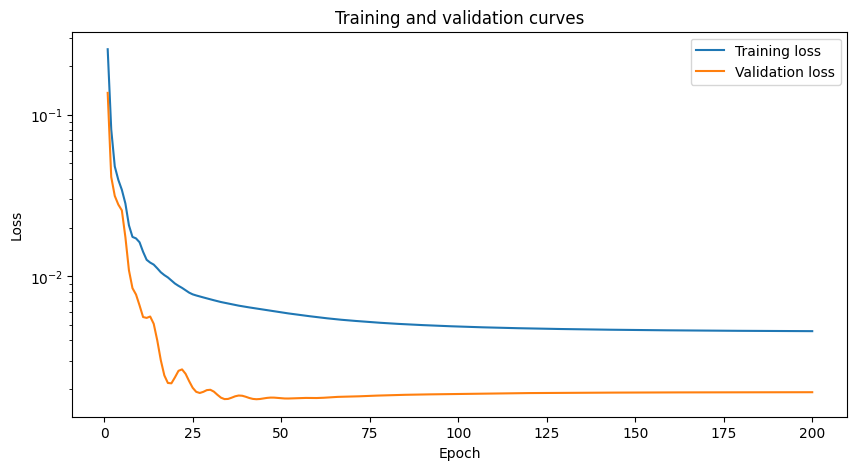

Test loss: 0.0019177482463419437


In [96]:
visualise_training_log(training_log)

light_gru.eval()
with torch.no_grad():
    test_output = light_gru(U_test.to(DEVICE))
    test_loss = nn.MSELoss()(test_output, X_test.to(DEVICE))

print(f'Test loss: {test_loss.item()}')

We actually see loss converge to a value about an order of magnitude higher than the vanilla RNN model. This could be as a consequence of not having tuned the hyperparameters optimally, or perhaps I am not initialising the hidden layer weights optimally, or the light GRU architecture simply offers no improvement over a vanilla RNN for this dataset.

## Problem 4 - Neural ODEs

## 4.1

Creating delay embedded train-val-test split

In [ ]:
train_inds, test_inds = train_test_split(0.59, X.shape[0])

# forming delay embeddings for the training and test data
U_train = torch.from_numpy(np.stack([X[train_inds, :], U[train_inds, :]], axis=-1))
U_test = torch.from_numpy(np.stack([X[test_inds, :], U[test_inds, :]], axis=-1))

X_train = U_train[:, 1:-1, 0].squeeze().float()
Y_train = U_train[:, 2:, 0].squeeze().float()
X_test = U_test[:, 1:-1, 0].squeeze().float()
Y_test = U_test[:, 2:, 0].squeeze().float()

# clipping so that there is correspondence between U, X and Y
U_train = U_train[:, :-2, :].float() # ensuring float 32
U_test = U_test[:, :-2, :].float()

print(U_train.shape, U_test.shape, X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

torch.Size([64, 198, 2]) torch.Size([44, 198, 2]) torch.Size([64, 198]) torch.Size([64, 198]) torch.Size([44, 198]) torch.Size([44, 198])


## 4.2

Based on the delay embeddings, we can formulate the ODE in the following manner.

$$
\frac{dx}{dt} = f(x_{t-1}, u_{t-1})
$$

where f is a black box DNN consisting of fully connected feedforward layers and $x_t$ is the current state of the neural ODE and $x_{t-1}$ and $u_{t-1}$ form the external input at time $t$. If $u_{t-1} = 0$, the system would be predicting the evolution of the state (displacement) without forcing.

In [ ]:
# from the lab notebook...

class Neural_ODE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers):
        super().__init__()
        # Define the feedforward neural network
        network = [nn.Linear(input_size, hidden_size), nn.ELU()]
        for _ in range(layers - 1): # Add hidden layers - as many as specified
            network.extend([nn.Linear(hidden_size, hidden_size), nn.ELU()])
        network.append(nn.Linear(hidden_size, output_size)) # final layer is not followed by an activation function so that the output is unbounded
        self.network = nn.Sequential(*network)
    
    def forward(self, x, input, steps, stepsize):
        """
        forward call using the euler method to approximate the ivp solution.

        args:
        -----
        x: ndarray - current state of the system with shape (batch_size, output_size)
        input: ndarray - input to the system with shape (batch_size, input_size)
        steps: int - number of steps to take
        stepsize: float - stepsize for the ODE solver

        returns:
        --------
        out: ndarray - output of the system at each time step with shape (batch_size, steps, output_size)
        """
        out = torch.zeros(x.shape[0], steps, x.shape[1]).to(x.device) # initial condition is not included
        
        # euler method
        for i in range(steps):
            rhs = self.network(input).squeeze() # to get rid of the last dimension if it is 1
            x = x + stepsize * rhs
            out[:, i, :] = x
        
        return out
    

## 4.3
Let's now train the neural ODE using single timestep predictions.

In [ ]:
def train_neural_ode(net: nn.Module, input_data: torch.Tensor, state_in: torch.Tensor, state_out: torch.Tensor, batch_size=32, 
                     num_epochs: int = 100, learning_rate: float = 0.01, betas: Tuple = (0.9, 0.999), clip_thresh: float = 1):
    """
    Trains RNN based net model for num_epochs epochs, using BPTT with cross entropy loss and Adam optimizer. 
    The learning rate is decayed exponentially using a scheduler so that the final learning rate is 1% of the
    initial learning rate.

    args:
    -----
    net: nn.Module - RNN network to train
    train_data: ndarray - training data with shape (batch_size, seq_len, input_size)
    val_data: ndarray - validation data with shape (batch_size, seq_len, input_size)
    
    optional:
    ---------
    num_epochs: int - number of epochs to train the model for. Default is 100
    learning_rate: float - learning rate for the Adam optimizer. Default is 0.001
    betas: Tuple - betas for the Adam optimizer. Default is (0.9, 0.999)
    clip_thresh: float - threshold for gradient clipping. Default is 1

    returns:
    --------
    net: nn.Module - best performing model instance
    training_log: dict - dictionary containing training and validation loss, learning rate and epoch number
    """
    
    # loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=betas)
    # using exponential learning rate scheduler for better stability once the loss is small.
    gamma = 0.01**(1/num_epochs) # setting gamma so that the final learning rate is 1% of the initial learning rate
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    # training log
    training_log = {'train_loss': [],  
                    'learning_rate': [],
                    'epoch': []}

    # determining the number of batches per epoch
    batches = input_data.shape[0] // batch_size
    if input_data.shape[0] % batch_size > 0:
        batches += 1

    best_model = None
    best_loss = np.inf
    
    # moving everything to the same device
    net = net.to(DEVICE)
    input_data = input_data.to(DEVICE)
    state_in = state_in.to(DEVICE)
    state_out = state_out.to(DEVICE)
    net.train()

    # training loop using BPTT
    for epoch in range(num_epochs):
        training_log['epoch'].append(epoch+1)
        
        for batch in range(batches):
            optimizer.zero_grad() # zeroing gradients before each forward pass to avoid accumulation
            
            # getting the current batch from the training data
            input_batch = input_data[batch*batch_size:(batch+1)*batch_size, :, :]
            state_in_batch = state_in[batch*batch_size:(batch+1)*batch_size, :]
            state_out_batch = state_out[batch*batch_size:(batch+1)*batch_size, :]

            # producing a prediction of the state at the next timestep SHOULD BE IN A LOOP
            batch_output = net(state_in_batch, input_batch, steps=1, stepsize=1/SAMPLE_RATE)  
            batch_output = batch_output.squeeze() # removing the extra dimension
    
            # calculating loss and backpropagating
            loss = criterion(batch_output, state_out_batch) # comparing next state prediction to the actual next state
        
            loss.backward()
            # implementing gradient clipping before stepping the optimizer
            # nn.utils.clip_grad_norm_(net.parameters(), clip_thresh)
            optimizer.step()
        
        # stepping the learning rate scheduler
        training_log['learning_rate'].append(scheduler.get_last_lr()[0])
        scheduler.step() # decaying the learning rate by gamma
        
        # logging training and validation loss at the end of each epoch
        training_log['train_loss'].append(loss.item())
        
        # saving best model
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = net.state_dict()

        if (epoch+1) % 10 == 0:
            print('--------------------------------')
            print(f'Epoch {epoch+1}, train Loss: {loss.item()}')
            print('--------------------------------\n')

    # once training is complete, we can load the best model, and return the training log
    net.load_state_dict(best_model)
    net.eval()

    return net, training_log

In [ ]:
ode_net = Neural_ODE(input_size=2, hidden_size=20, output_size=1, layers=5)
ode_net, training_log = train_neural_ode(ode_net, U_train, X_train, Y_train, num_epochs=200, learning_rate=0.1, batch_size=32)

--------------------------------
Epoch 10, train Loss: 0.003980262670665979
--------------------------------

--------------------------------
Epoch 20, train Loss: 0.003823490347713232
--------------------------------

--------------------------------
Epoch 30, train Loss: 0.003432437079027295
--------------------------------

--------------------------------
Epoch 40, train Loss: 0.003088257508352399
--------------------------------

--------------------------------
Epoch 50, train Loss: 0.0027438525576144457
--------------------------------

--------------------------------
Epoch 60, train Loss: 0.002706639003008604
--------------------------------

--------------------------------
Epoch 70, train Loss: 0.0026881799567490816
--------------------------------

--------------------------------
Epoch 80, train Loss: 0.0026826076209545135
--------------------------------

--------------------------------
Epoch 90, train Loss: 0.0026764634530991316
--------------------------------

------

Visualising the training loss curve shows a plateau in the training after only 25 epochs

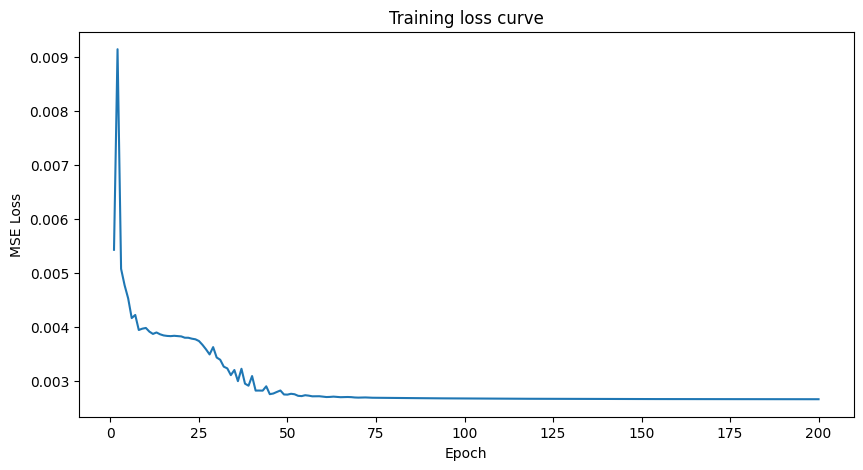

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(training_log['epoch'], training_log['train_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training loss curve')
plt.show()

## 4.4

Let's plot the prediction for a single test time series using the trained neural ODE

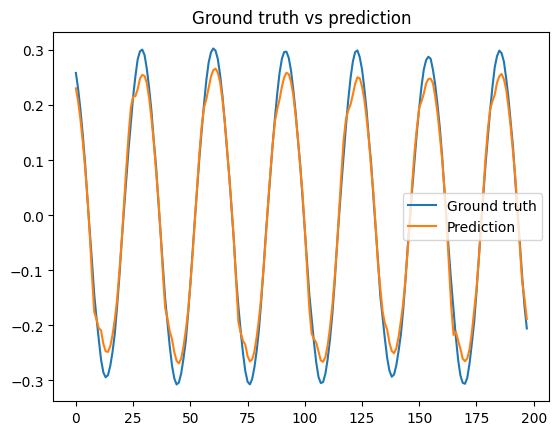

In [ ]:
randind = np.random.randint(0, U_test.shape[0])
U_rand = U_test[randind].unsqueeze(0).to(DEVICE)
X_rand = X_test[randind].unsqueeze(0).to(DEVICE)
Y_rand = Y_test[randind].unsqueeze(0)

Y_pred = ode_net(X_rand, U_rand, steps=1, stepsize=1/SAMPLE_RATE)

Y_pred = Y_pred.squeeze().detach().cpu().numpy()
Y_rand = Y_rand.squeeze().detach().cpu().numpy()


plt.plot(Y_rand, label='Ground truth')
plt.plot(Y_pred, label='Prediction')
plt.legend()
plt.title('Ground truth vs prediction')
plt.show()

Let's calculate error on the full test set

In [ ]:
# moving the test data to the correct device
X_test = X_test.to(DEVICE)
Y_test = Y_test.to(DEVICE)
U_test = U_test.to(DEVICE)

# getting test predictions
Y_pred = ode_net(X_test, U_test, steps=1, stepsize=1/SAMPLE_RATE)
Y_pred = Y_pred.squeeze()

critereon = nn.MSELoss()
test_loss = critereon(Y_pred, Y_test)

print(f'Test MSE loss: {test_loss.item()}')

Test MSE loss: 0.004313918296247721


So the test error is comparible to the train error which is good and similar to the test error of the vanilla RNN.

## 4.5

We've seen from the training that both networks perform similarly when tasked with predicting the next timestep. The advantage of using the neural ODE approach over an RNN is that the neural ODE model is not restricted to the sampling rate that it is trained on, since it learns the vector field of the dynamical system, that can be integrated to give the solution at any point. RNNs on the other hand, learn the solution of the dynamical system at fixed points in time, and are much more sensitive to nonlinearities in the solution.

Since this task involves predicting timeseries data generated by a physical system in continuous time, in principle the neural ODE approach makes more sense, as we could even potentially analyse the phase space to learn underlying behaviours of the system. That being said, given the absence of any obvious nonlinearities in the data, the RNN approach is perfectly adequate.

In fact, since we have a 2 dimensional input space, let's visualise the $dx/dt$ scalar field it produces.

(100, 100)


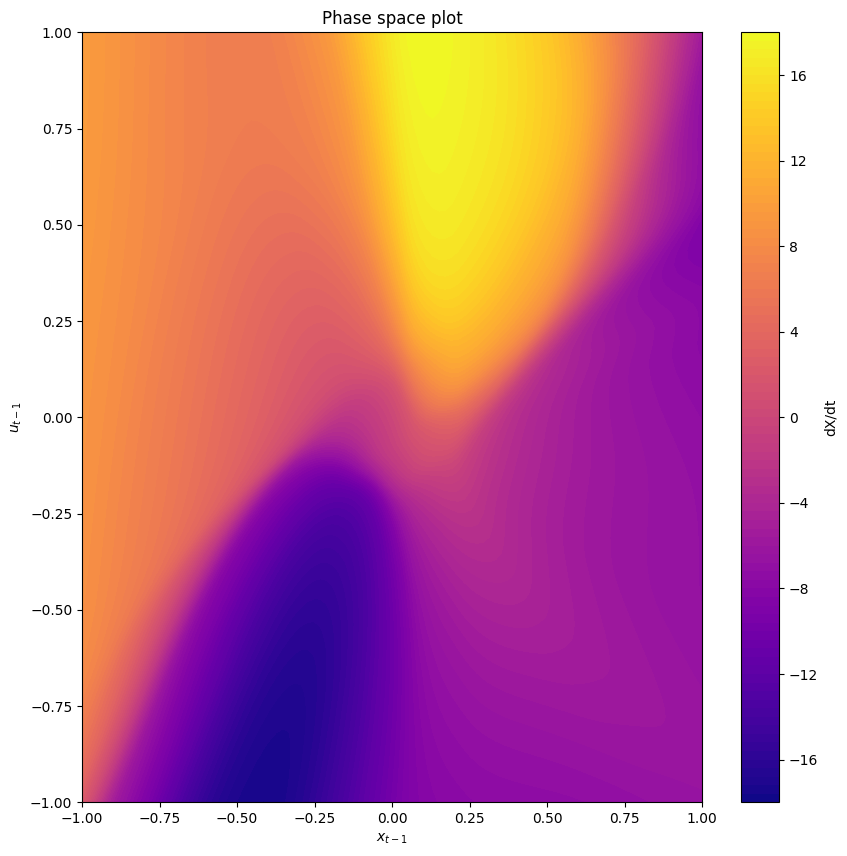

In [ ]:
x_in = np.linspace(-1, 1, 100)
u_in = np.linspace(-1, 1, 100)

X_in, U_in = np.meshgrid(x_in, u_in)

inputs = np.stack([X_in.flatten(), U_in.flatten()], axis=-1)
inputs = torch.from_numpy(inputs).float().to(DEVICE)
dX_dt = ode_net.network(inputs)

dX_dt = dX_dt.squeeze().unflatten(0, (100, 100)).detach().cpu().numpy()
print(dX_dt.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cax = ax.contourf(X_in, U_in, dX_dt, cmap='plasma', levels=100)
fig.colorbar(cax, ax=ax, label='dX/dt')
ax.set_xlabel('$x_{t-1}$')
ax.set_ylabel('$u_{t-1}$')
ax.set_title('Phase space plot')
plt.show()

We can observe from the countour plot visualisation of the learned scalar field of the ode_net that the maximum velocity is produced when the force acts in the same direction as the displacement and perhaps suprisingly negative and positive velocities cannot be linearly seperated in the phase space. Finally, there is a clear stable equillibrium in the centre of the plot